# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load dependencies
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten


In [2]:
training_file = 'train.p'
validation_file = 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# simple test to ensure that the data sets have the proper count of data
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
n_train = X_train.shape[0]

n_validation = X_valid.shape[0]

n_test = X_test.shape[0]

image_shape = X_train[0].shape

n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

In [4]:
%matplotlib inline

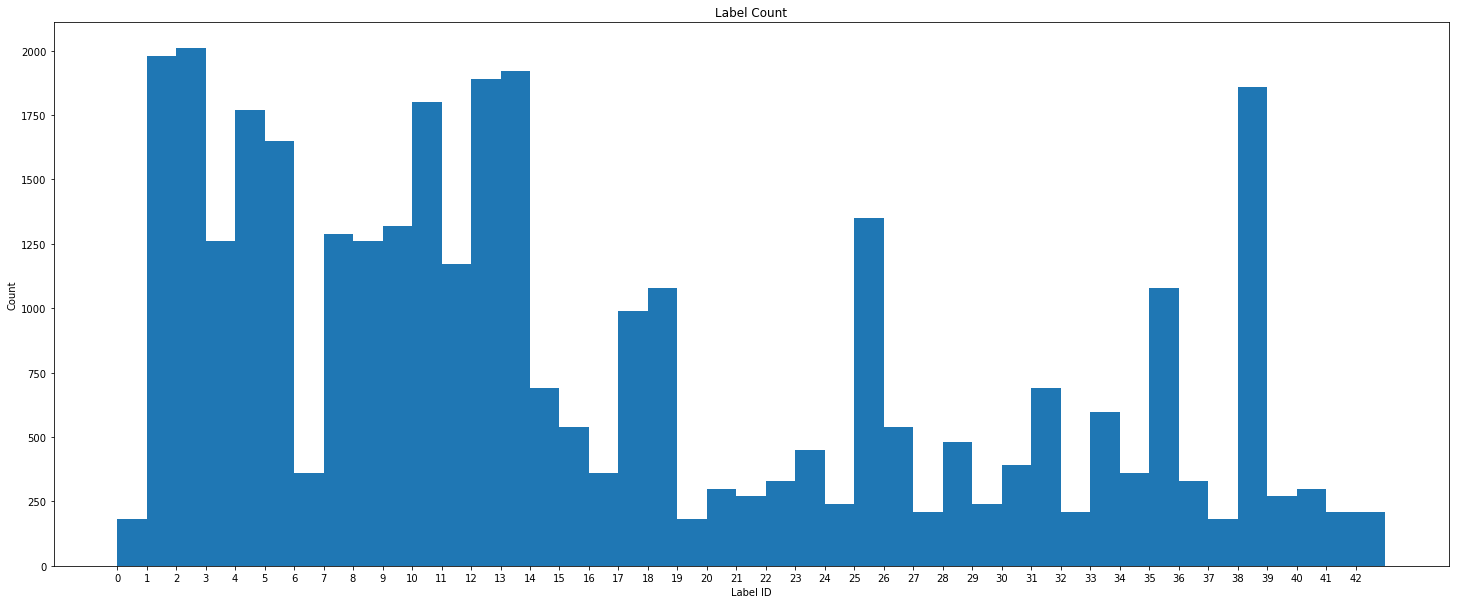

In [5]:
bins = np.arange(44)
plt.figure(figsize=(25, 10))
plt.xticks(np.arange(0,43,1))
plt.hist(y_train, bins=bins,)
plt.title("Label Count")
plt.ylabel("Count")
plt.xlabel("Label ID")
plt.show();

----

## Model Architecture Design and Test

In [7]:
class Preprocessor(object):
    
    @staticmethod
    def grayscale(data):
        return (np.dot(data[...][...], [0.299, 0.587, 0.114]))
    
    @staticmethod
    def reshape_grayscale(data):
        return np.reshape(data, data.shape + (1,))

    @staticmethod
    def normalize_grayscale(data):
        return data/255


In [8]:
def preprocess(data):
    return Preprocessor.normalize_grayscale(Preprocessor.reshape_grayscale(Preprocessor.grayscale(data)))

In [9]:
X_train_gray = preprocess(X_train)
X_valid_gray = preprocess(X_valid)
X_test_gray = preprocess(X_test)

### Model Architecture

#### Architecture

The achitecture object is a wrapper around the TensorFlow API use to obfuscate and modularize the pipeline.

In [10]:
class Architecture(object):

    def __init__(self):
        pass
    
    def conv_net_layer(self, input, filter_shape, output_depth, name='derp', mean=0, stddev=0.1):
        tf_W = tf.Variable(tf.truncated_normal(shape=filter_shape, mean = 0, stddev = 0.1))
        tf_b = tf.Variable(tf.zeros(output_depth))
        tf_layer = tf.nn.conv2d(input=input, filter=tf_W, strides=[1, 1, 1, 1], padding='VALID', name=name) + tf_b
        return tf.nn.relu(tf_layer)
    
    def max_pooling_layer(self, layer):
        return tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
    def dropout_layer(self, layer, threshold = 1.):
        return tf.nn.dropout(layer, threshold)
    
    def fully_connected_layer(self, input, n_input, n_output, mean=0, stddev=0.1, relu=False):
        tf_W = tf.Variable(tf.truncated_normal(shape=[n_input, n_output], mean=mean, stddev=stddev))
        tf_b = tf.Variable(tf.zeros(n_output))
        tf_layer   = tf.matmul(input, tf_W) + tf_b
    
        if relu:
            tf_layer = tf.nn.relu(tf_layer)
    
        return tf_layer


In [5]:
# The pipeline

def LeNet(x, keep_prob):
    a = Architecture()

    cn1 = a.conv_net_layer(x, [5,5,1,16], 16, 'conv1')
    cn2 = a.conv_net_layer(cn1, [5,5,16,32], 32, 'conv2')
    cn3 = a.conv_net_layer(cn2, [5,5,32,64], 64, 'conv3')
    mp1 = a.max_pooling_layer(cn3)
    f1 = flatten(mp1)
    fc1 = a.fully_connected_layer(f1, 6400, 1600, relu=True)
    fc2 = a.fully_connected_layer(fc1, 1600, 400, relu=False)
    d0 = a.dropout_layer(fc2, keep_prob)
    fc3 = a.fully_connected_layer(d0, 400, 43, relu=False)
    d1 = a.dropout_layer(fc3, keep_prob)
    
    return d1

In [12]:
## Training Pipeline

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.001 # changed from 0.0001 to 0.001
EPOCHS = 15
BATCH_SIZE = 256
valid_acc_list = []
train_acc_list = []

logits = LeNet(x, keep_prob)

y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, keep_prob):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [13]:
start = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_gray)

    print('Training...')
    
    for i in range(EPOCHS):
        shuffled_X_train, shuffled_y_train = shuffle(X_train_gray, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = shuffled_X_train[offset:end], shuffled_y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        training_accuracy = evaluate(X_train_gray, y_train, keep_prob)
        train_acc_list.append(training_accuracy)
        
        validation_accuracy = evaluate(X_valid_gray, y_valid, keep_prob)
        valid_acc_list.append(validation_accuracy)
            
        print(("[ EPOCH {} ".format(i+1)).ljust(12) 
              + " | Training Accuracy = {:.3f}".format(training_accuracy) 
              + " | Validation Accuracy = {:.3f} ]".format(validation_accuracy))
        
    saver.save(sess, './lenet')
    print('Model saved')
       
    end = time.time()
    print('Time', end - start)        

Training...
[ EPOCH 1    | Training Accuracy = 0.939 | Validation Accuracy = 0.879 ]
[ EPOCH 2    | Training Accuracy = 0.983 | Validation Accuracy = 0.936 ]
[ EPOCH 3    | Training Accuracy = 0.992 | Validation Accuracy = 0.949 ]
[ EPOCH 4    | Training Accuracy = 0.996 | Validation Accuracy = 0.959 ]
[ EPOCH 5    | Training Accuracy = 0.998 | Validation Accuracy = 0.964 ]
[ EPOCH 6    | Training Accuracy = 0.999 | Validation Accuracy = 0.963 ]
[ EPOCH 7    | Training Accuracy = 0.999 | Validation Accuracy = 0.963 ]
[ EPOCH 8    | Training Accuracy = 0.999 | Validation Accuracy = 0.969 ]
[ EPOCH 9    | Training Accuracy = 1.000 | Validation Accuracy = 0.971 ]
[ EPOCH 10   | Training Accuracy = 1.000 | Validation Accuracy = 0.971 ]
[ EPOCH 11   | Training Accuracy = 1.000 | Validation Accuracy = 0.970 ]
[ EPOCH 12   | Training Accuracy = 1.000 | Validation Accuracy = 0.974 ]
[ EPOCH 13   | Training Accuracy = 1.000 | Validation Accuracy = 0.974 ]
[ EPOCH 14   | Training Accuracy = 1.00

### Train, Validate and Test the Model

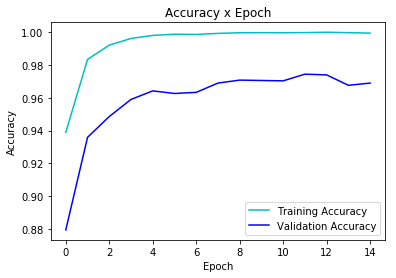

In [14]:
plt.plot(train_acc_list,'c', label='Training Accuracy')
plt.plot(valid_acc_list, 'b', label='Validation Accuracy')
plt.legend(loc=4)
# plt.tight_layout()
plt.figure(1, figsize=(5,5))
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Accuracy x Epoch")
plt.savefig('accuracy_x_epoch.png')
plt.show()


A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_gray, y_test, keep_prob)
    print('Test Accuracy = {:.3f}'.format(test_accuracy))

---

## Model Testing

### Load and Output the Images

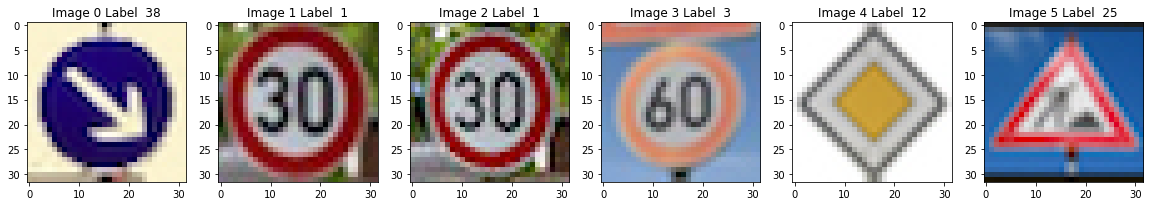

In [18]:
X_new = np.empty([6, 32, 32, 3], dtype=np.uint8)
y_new = np.array([38, 1, 1, 3, 12, 25], dtype=np.uint8) 

new_images = []
folder = "samples"
for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename))
    if img is not None:
        new_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.figure(1, figsize=(20,20))
for i in range(len(new_images)):
    img = new_images[i]
    plt.subplot(1,6, i+1)
    plt.title("Image " + str(i) + " Label  " + str(y_new[i]))
    plt.imshow(img)
    
plt.savefig('test_images.png')
              

(6, 32, 32, 3)


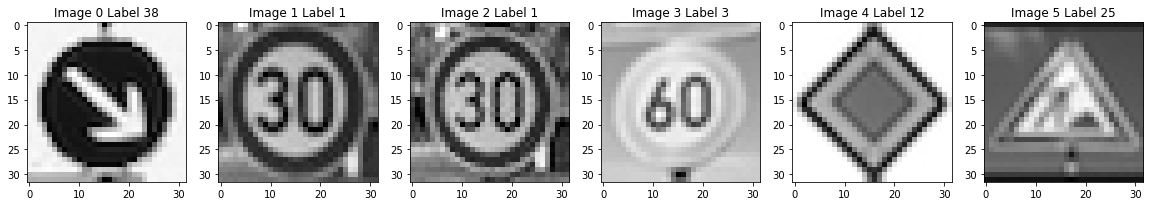

In [19]:
# Pre-proccess the images  

for i in range(len(X_new)):
    X_new[i,:,:,:] = new_images[i]

print(X_new.shape)

X_new_gray = preprocess(X_new)

plt.figure(1, figsize=(20,20))
for i in range(len(X_new_gray)):
    plt.subplot(1,6, i+1)
    plt.title("Image " + str(i) + " Label " + str(y_new[i]))
    plt.imshow(X_new_gray[i,:,:,0],cmap='gray')

plt.savefig('test_images_gray.png')    

### Predict the Sign Type for Each Image

In [20]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    new_accuracy = evaluate(X_new_gray, y_new, keep_prob)
    print("New Test Data Accuracy = {:.3f}".format(new_accuracy))

New Test Data Accuracy = 1.000


### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [22]:
### Top 5 softmax values

pred = tf.nn.top_k(y_pred,k=5)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    feed_dict = {x: X_new_gray, y: y_new, keep_prob: 1.0}
    top_5_predictions = sess.run(pred, feed_dict=feed_dict)
    
print(top_5_predictions)

TopKV2(values=array([[  1.00000000e+00,   2.44970627e-10,   1.31388692e-10,
          8.58027260e-11,   7.72768516e-11],
       [  5.22093773e-01,   2.08591729e-01,   9.25991014e-02,
          6.09156787e-02,   3.65989543e-02],
       [  9.99999762e-01,   1.78362114e-07,   6.29242702e-09,
          4.65835681e-09,   3.41078654e-09],
       [  9.71571982e-01,   2.05412637e-02,   1.48868386e-03,
          8.68494099e-04,   5.62630710e-04],
       [  9.99900460e-01,   9.82872007e-05,   6.04099966e-07,
          4.11958439e-07,   8.65028369e-08],
       [  8.31483126e-01,   1.21691912e-01,   7.75897084e-03,
          7.66920578e-03,   6.56152796e-03]], dtype=float32), indices=array([[38, 31,  8, 11, 13],
       [ 1, 14,  6,  3, 12],
       [ 1,  0, 14, 12,  5],
       [ 3,  0,  8, 41, 31],
       [12, 15, 40, 14,  5],
       [25,  0, 39, 11, 22]], dtype=int32))


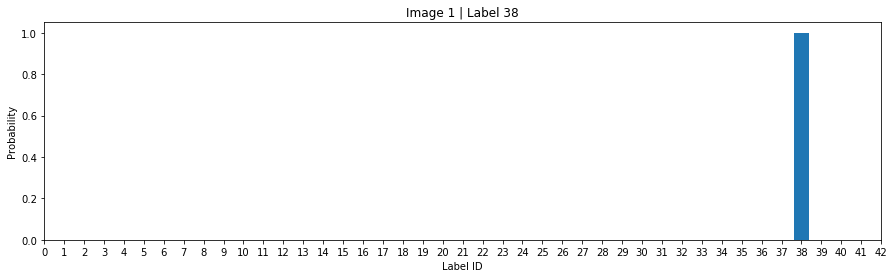

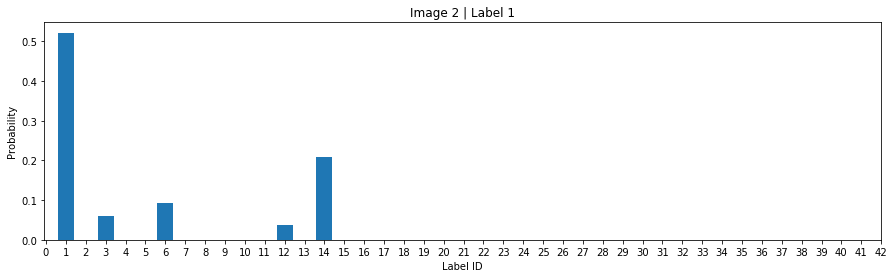

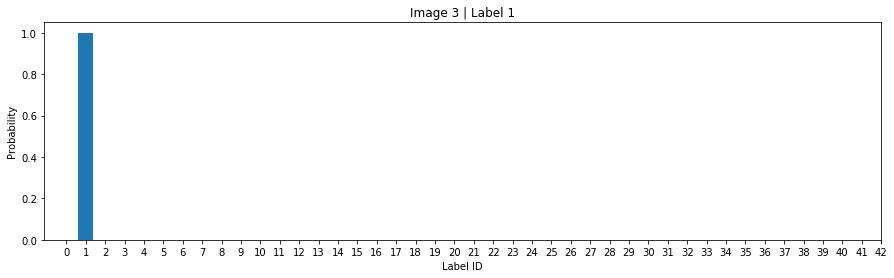

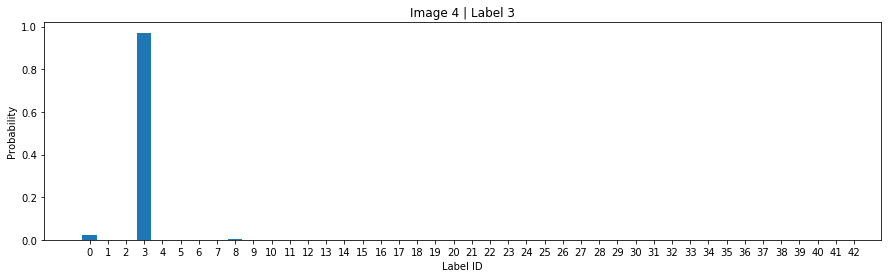

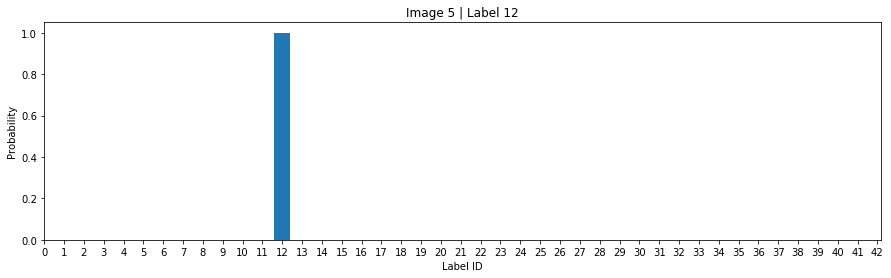

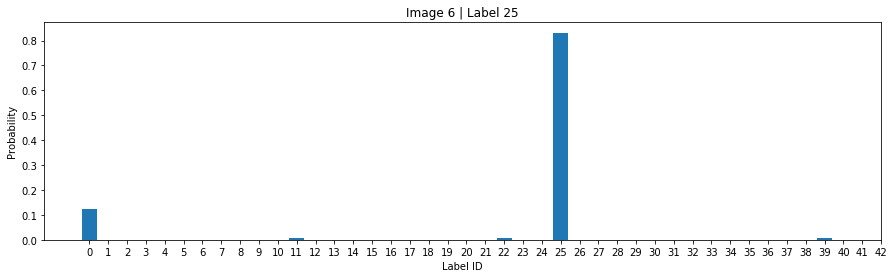

In [26]:
for i in range(6):
    plt.figure(figsize = (15,4))
    plt.bar(top_5_predictions[1][i], top_5_predictions[0][i], align="center")
    plt.xticks(np.arange(0,43,1))
    
    plt.title("Image " + str(i+1) + " | Label " + str(y_new[i]))
    plt.ylabel("Probability")
    plt.xlabel("Label ID")
    plt.savefig("bar_softmax_{}.png".format(i+1))
    plt.show();

In [31]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.axis('off')
        plt.subplot(8,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
        
    plt.savefig('conv_feature_map.png')

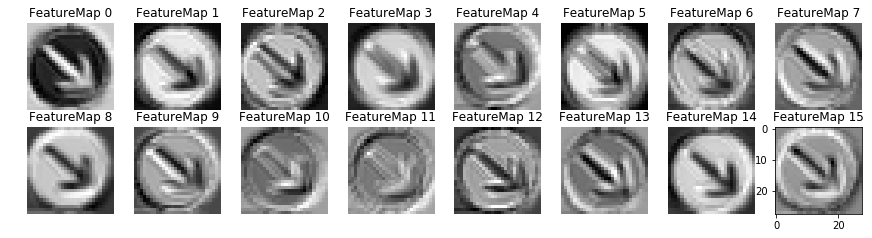

In [32]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    conv_layer_1_visual = sess.graph.get_tensor_by_name('conv1:0')
    outputFeatureMap(X_new_gray, conv_layer_1_visual)

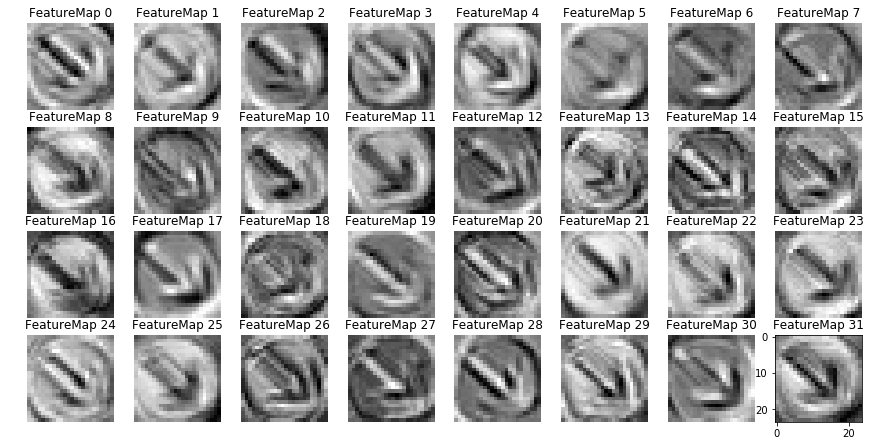

In [33]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    conv_layer_2_visual = sess.graph.get_tensor_by_name('conv2:0')
    outputFeatureMap(X_new_gray, conv_layer_2_visual)

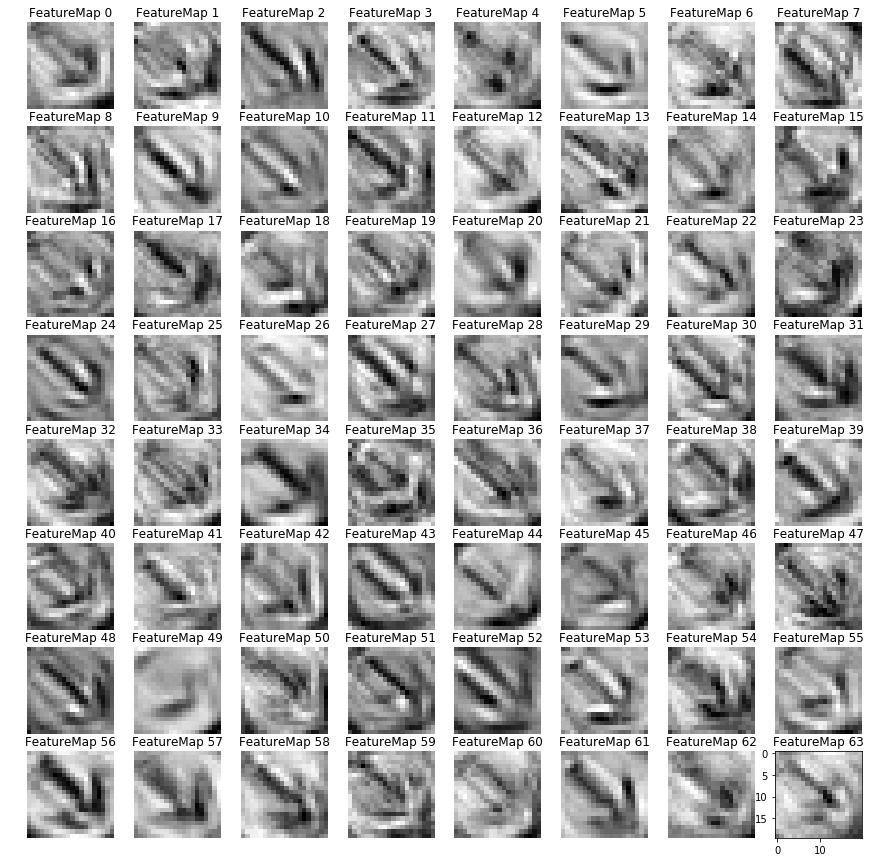

In [34]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    conv_layer_3_visual = sess.graph.get_tensor_by_name('conv3:0')
    outputFeatureMap(X_new_gray, conv_layer_3_visual)

In [50]:
import math    

test_image = X_train_gray[0]

def drawFilters(layer, stimuli, file_name='derp.png'):
    units = sess.run(layer,feed_dict={x:stimuli})
    filters = units.shape[3]
    plt.figure(1, figsize=(25,25))
    n_columns = 8
    n_rows = math.ceil(filters / n_columns) + 1
    
    for i in range(filters):
        plt.axis('off')
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
        
    plt.savefig(file_name)

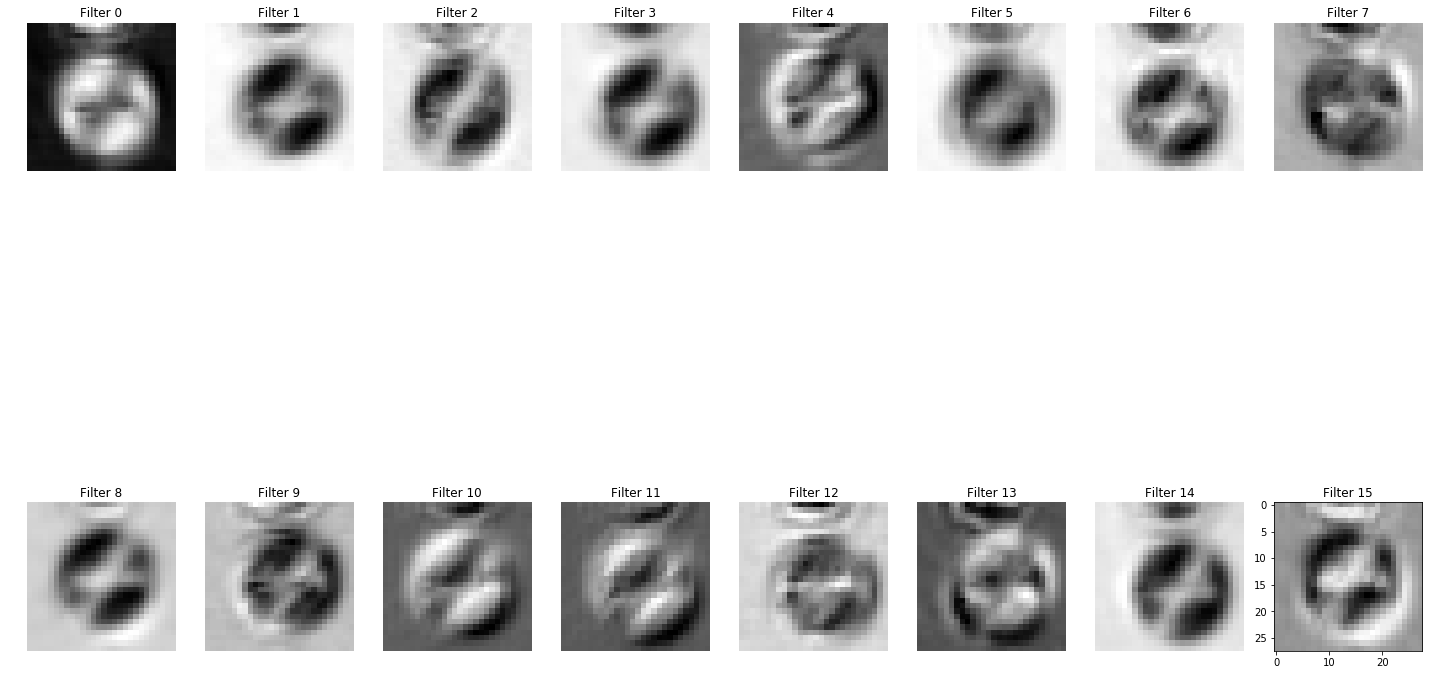

In [51]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    conv_layer_1_visual = sess.graph.get_tensor_by_name('conv1:0')
    drawFilters(conv_layer_1_visual,[test_image], 'conv1_filter.png')

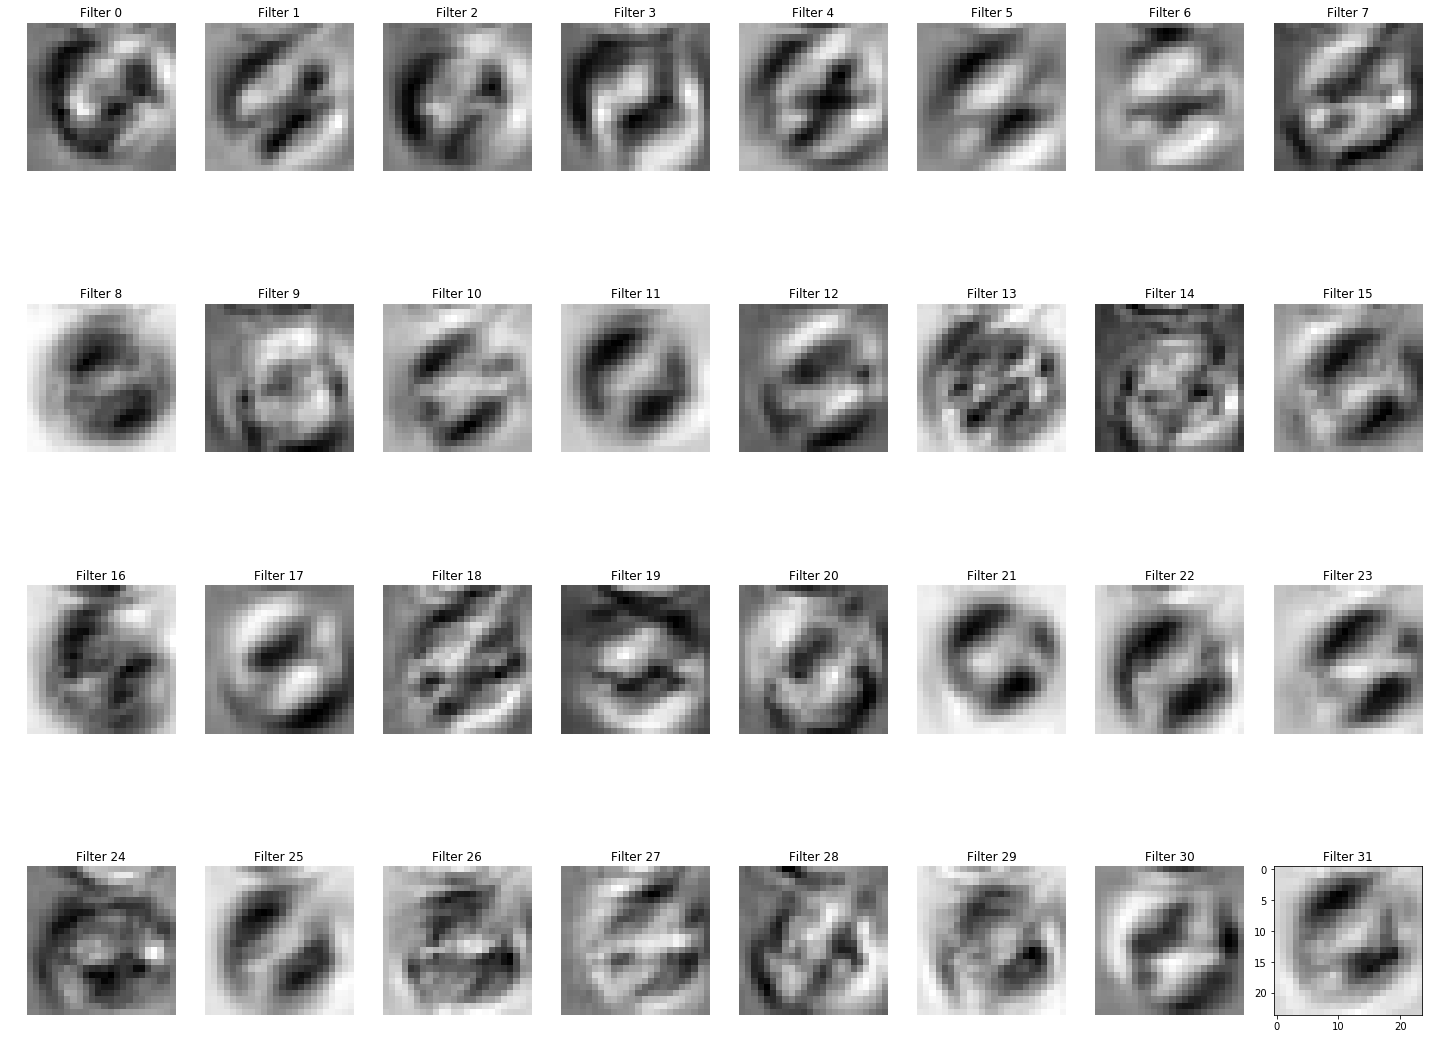

In [52]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    conv_layer_2_visual = sess.graph.get_tensor_by_name('conv2:0')
    drawFilters(conv_layer_2_visual,[test_image], 'conv2_filter.png')

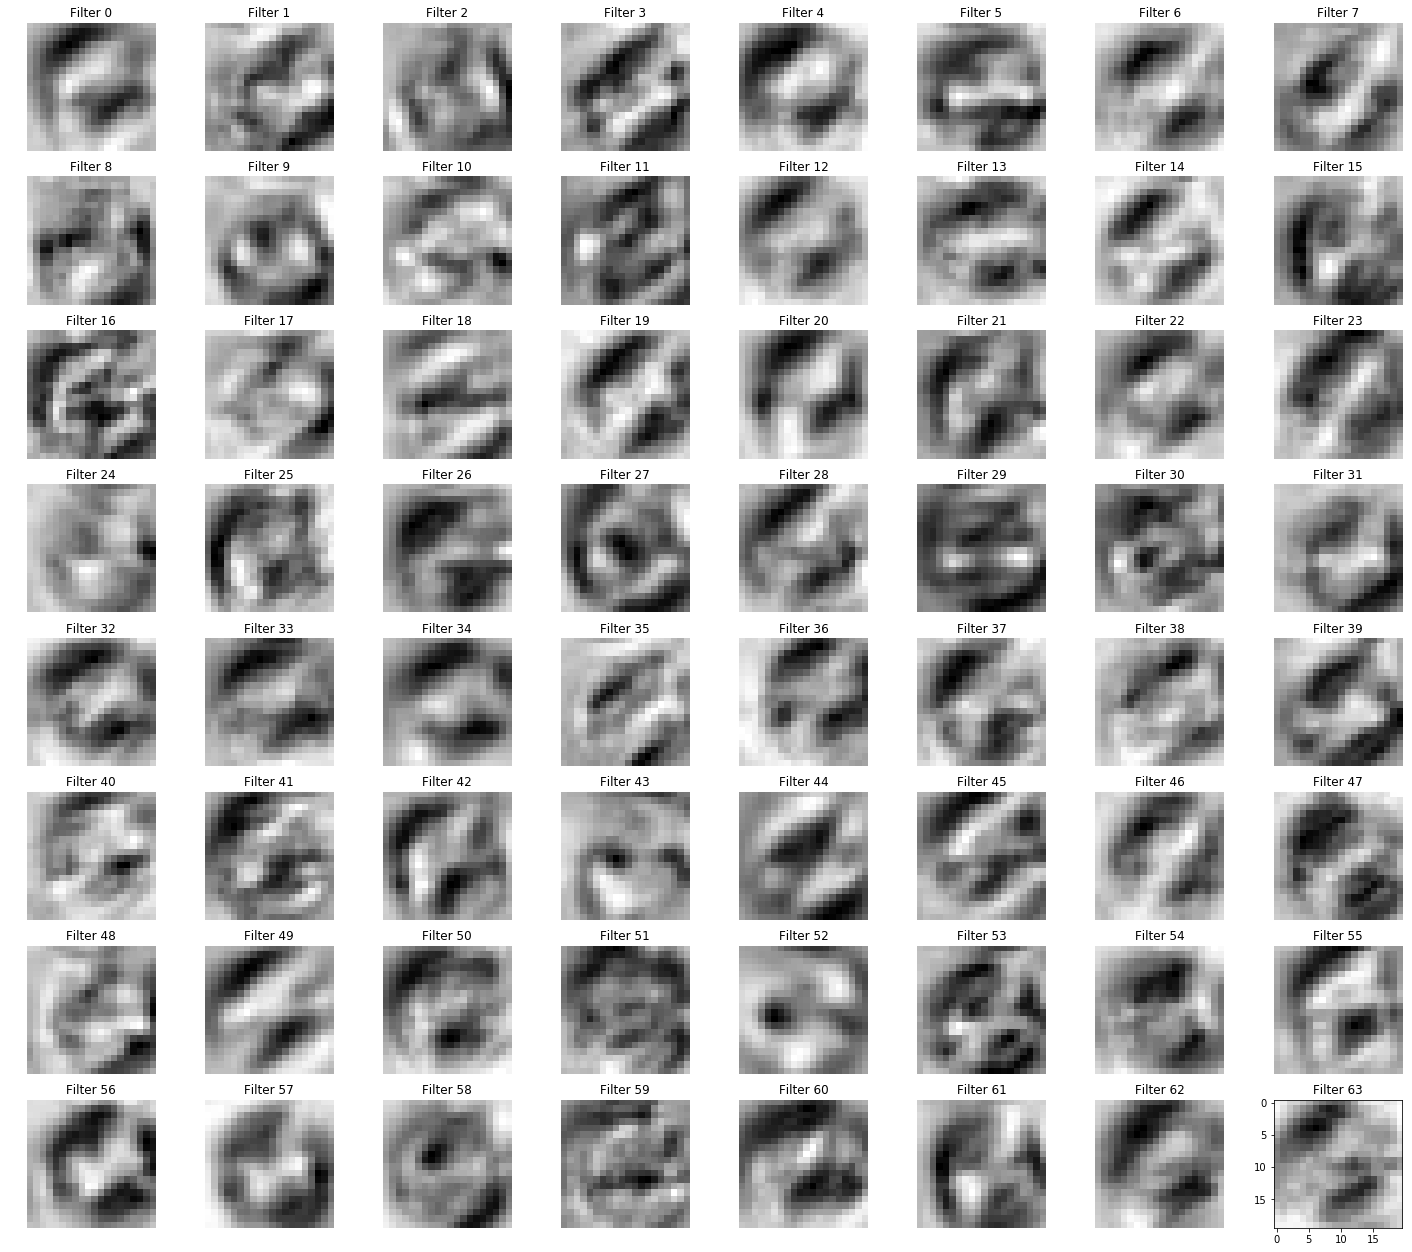

In [53]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    conv_layer_3_visual = sess.graph.get_tensor_by_name('conv3:0')
    drawFilters(conv_layer_3_visual,[test_image], 'conv3_filter.png')